# Project: Computer Vision Capstone Project:
# Distracted Driver Posture Classification

## Description: 
The Center for Disease Control and Prevention (CDC) found that nearly one in five vehicle accidents are caused due to distracted driving [1]. This statistics has led to more than 3,000 fatal injuries and 425,000 injuries every year in the USA. This project is taken from a Kaggle competition [2] and the purpose of this project is to classify the action of the drivers which they are doing in the provided images and whether they are distracted or not[3].
The major cause of these accidents was the use of mobile phones. The National Highway Traffic Safety Administration (NHTSA) defines distracted driving as “any activity that diverts attention from driving”, including: a) talking or texting on one’s phone, b) eating and drinking, c) talking to passengers, or d) fiddling with the stereo, entertainment, or navigation system [4]. The CDC provides a broader definition of distracted driving by taking into account visual (i.e. taking one’s eyes off the road), manual (i.e. taking one’s hands off the driving wheel) and cognitive (i.e. taking one’s mind off driving) causes [5].
State Farm created a computer vision competition on Kaggle, a platform that provides data science projects and company sponsored competitions. The company is challenging competitors to classify the driver’s behavior.


## Data
Data is a collection of 10 different states of drivers containing one safe driving and 9 other distracted modes. The dataset is provided by State Farm through Kaggle which can be downloaded from [here](https://www.kaggle.com/c/state-farm-distracted-driver-detection/data). This project is sponsored by State Farm on Kaggle website. State Farm aims to reduce these alarming statistics, and better insure their customers, by detecting the driver’s distracting activity from the dashboard cameras. Given a dataset of 2D dashboard camera images, State Farm is challenging Kagglers to classify each driver's behavior [2]. Are they driving attentively, wearing their seatbelt, or taking a selfie with their friends in the backseat?
The dataset consists of an “imgs” folder that has a test and train folder of 640 x 480 jpg files. The images were taken by a dashboard camera. Each image consists of a driver performing a task from one of the distracted tasks. There are no duplicate images in the dataset. Also State Farm removed metadata from each image (e.g. creation dates). State Farm set up these experiments in a controlled environment. While performing each task, the drivers were not driving as a truck dragged the car on the streets.
Below I listed the number of files for each category in the training data and the test data.

In total, there are 22,424 training examples. “Safe driving” has the most examples, and “Hair and makeup” the least. It makes sense to have a lot of “safe driving“examples because State farm is in general interested in finding out if the driver is driving safely or not. They would rather have false negatives than false positives when labeling safe driving. More examples would improve the classifier’s performance in decreasing false positives for safe driving. “Hair and makeup” may be less because it is a task mostly performed by women.


## Analysis
The State Farm supplied the data for a Kaggle challenge. The dataset consists of 22,400 training and 79,727 testing images (640 × 480 with RGB colors) of drivers either driving attentively or doing one of 9 classes of distracting behaviors [3] [8]. 

## Tools

The project utilizes the following dependencies:

- Python 3.6: Tensorflow, Keras, Numpy
- NVIDIA Geforce GTX1050 GPU, CUDA, CuDNN

# 1. Import dependencies

Check GPU and CPU device availability.


In [1]:
from tensorflow.python.client import device_lib
[x.physical_device_desc for x in device_lib.list_local_devices() if x.device_type == 'GPU']
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12791665773499620215
]


Basic import, if anything needed during the development process, dump here.

In [81]:
import math, os, sys
import pickle
from glob import glob
import numpy as np
from numpy.random import random, permutation, randn, normal
from matplotlib import pyplot as plt
import plotly as py
import plotly.plotly as ploty
from plotly.offline import download_plotlyjs, init_notebook_mode, plot,iplot
import plotly.graph_objs as go
%matplotlib inline
import PIL
from PIL import Image
import bcolz
from shutil import copyfile
from shutil import move
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.preprocessing import Imputer, LabelEncoder, OneHotEncoder, StandardScaler
import itertools
import random
from extract_bottleneck_features import *
import cv2 


import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input,  GlobalAveragePooling2D, AveragePooling2D, GlobalAveragePooling1D, GlobalMaxPooling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing import image
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical
from keras.metrics import categorical_crossentropy
from keras.regularizers import l2,l1


# Create some handy functions

In [105]:
def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True, 
                batch_size=1, target_size=(224,224), class_mode='categorical'):
    return gen.flow_from_directory(path+dirname, target_size, 
                class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
        plt.show()

def get_classes(path):
    batches = get_batches('train', shuffle=False, batch_size=1)
    val_batches = get_batches('valid', shuffle=False, batch_size=1)
    #test_batches = get_batches('test', shuffle=False, batch_size=1)
    return (val_batches.classes, 
            batches.classes,
            #test_batches.classes,
            to_categorical(val_batches.classes),
            to_categorical(batches.classes),
            #to_categorical(test_batches.classes),
            val_batches.filenames, 
            batches.filenames)
            #test_batches.filenames)
            # test_batches.filenames)

def get_data(path, target_size = (224,224), batch_size=batch_size):
    batches = get_batches(path, shuffle=False, batch_size=1, class_mode=None, target_size=target_size)
    return np.concatenate([batches.next() for i in range (len(batches.classes))])

def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()
    
def load_array(fname):
    return bcolz.open(fname)[:]

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
def plot_history(Exp_history):
    plt.figure(1)
    plt.subplot(211)
    plt.plot(Exp_history.history['acc'])
    plt.plot(Exp_history.history['val_acc'])
    plt.title('accuracy')
    plt.ylabel('accuracy')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.subplot(212)
    plt.plot(Exp_history.history['loss'])
    plt.plot(Exp_history.history['val_loss'])
    plt.title('loss')
    plt.ylabel('loss')
    plt.xlabel('epoches')
    plt.legend(['train', 'validation'], loc='upper left')
   
    #plt.savefig(results_path+'/train_history/Exp_train_history_1.png', bbox_inches='tight')
    plt.show()


def plot_acc(Exp_history):
    plt.figure(1)
    plt.plot(Exp_history.history['acc'])
    plt.plot(Exp_history.history['val_acc'])
    plt.title('accuracy')
    plt.ylabel('accuracy')
    plt.legend(['train', 'validation'], loc='upper left')
    #plt.savefig(results_path+'/train_history/Exp_train_history_1.png', bbox_inches='tight')
    plt.show()

# 1. Data preparation and exploration

As provided, the train dataset contains the following categories of driving states:

- c0: safe driving
- c1: texting - right
- c2: talking on the phone - right
- c3: texting - left
- c4: talking on the phone - left
- c5: operating the radio
- c6: drinking
- c7: reaching behind
- c8: hair and makeup
- c9: talking to passenger

## 1.1 Prepare data directories
As general, we will distribute the training data into train and validation sets. 


In [ ]:

#%cd project

%pwd

In [12]:
current_dir = os.getcwd()
PROJECT_DIR = current_dir
path = current_dir+'/imgs/'
test_path = path + '/test/' #We use all the test data
train_path = path + '/train/'
result_path = path + '/results/'
valid_path = path + '/valid/'

WARNING: These lines are only to run once.

In [13]:
'''%cd $path
%mkdir valid
%mkdir results
%mkdir models'''

'%cd $path\n%mkdir valid\n%mkdir results\n%mkdir models'

In [14]:
'''# Creating validation set
%cd $valid_path
%mkdir c0
%mkdir c1
%mkdir c2
%mkdir c3
%mkdir c4
%mkdir c5
%mkdir c6
%mkdir c7
%mkdir c8
%mkdir c9
%cd $path
%cd $path'''


'# Creating validation set\n%cd $valid_path\n%mkdir c0\n%mkdir c1\n%mkdir c2\n%mkdir c3\n%mkdir c4\n%mkdir c5\n%mkdir c6\n%mkdir c7\n%mkdir c8\n%mkdir c9\n%cd $path\n%cd $path'

In [15]:
%cd $path

C:\Users\User\Downloads\udacity\project\imgs


In [16]:
class_labels = ['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9']

for i in class_labels:
    print ('label {0} has {1:5d} images'.format(i,len([name for name in os.listdir(train_path+i) 
                                                         if os.path.isfile(os.path.join(train_path+i, name))])))

label c0 has  1989 images
label c1 has  1767 images
label c2 has  1817 images
label c3 has  1846 images
label c4 has  1826 images
label c5 has  1812 images
label c6 has  1825 images
label c7 has  1502 images
label c8 has  1152 images
label c9 has  1238 images


In [17]:
summ = float(0)
for i in class_labels:
    summ = summ +len([name for name in os.listdir(train_path+i) if os.path.isfile(os.path.join(train_path+i, name))])
summ

16774.0

There are around 2000 images for each categories. It is probably a good idea to move 25% of images (500 images for each categories) to validation sets.

In [18]:
%cd $train_path

C:\Users\User\Downloads\udacity\project\imgs\train


In [19]:
'''# moving ~20% data from train sets to validation sets
for label in class_labels:
    g = glob(label+'/*.jpg')
    shuffle = np.random.permutation(g)
    for i in range(500): move(shuffle[i], valid_path+shuffle[i])'''

"# moving ~20% data from train sets to validation sets\nfor label in class_labels:\n    g = glob(label+'/*.jpg')\n    shuffle = np.random.permutation(g)\n    for i in range(500): move(shuffle[i], valid_path+shuffle[i])"

In [20]:
summ = float(0)
for i in class_labels:
    summ = summ +len([name for name in os.listdir(valid_path+i) if os.path.isfile(os.path.join(valid_path+i, name))])
summ

5000.0

In [21]:
summ = float(0)
summ = summ +len([name for name in os.listdir(test_path) if os.path.isfile(os.path.join(test_path, name))])
summ

79726.0

End Warning

## 1.2 Visualization

Found 16774 images belonging to 10 classes.


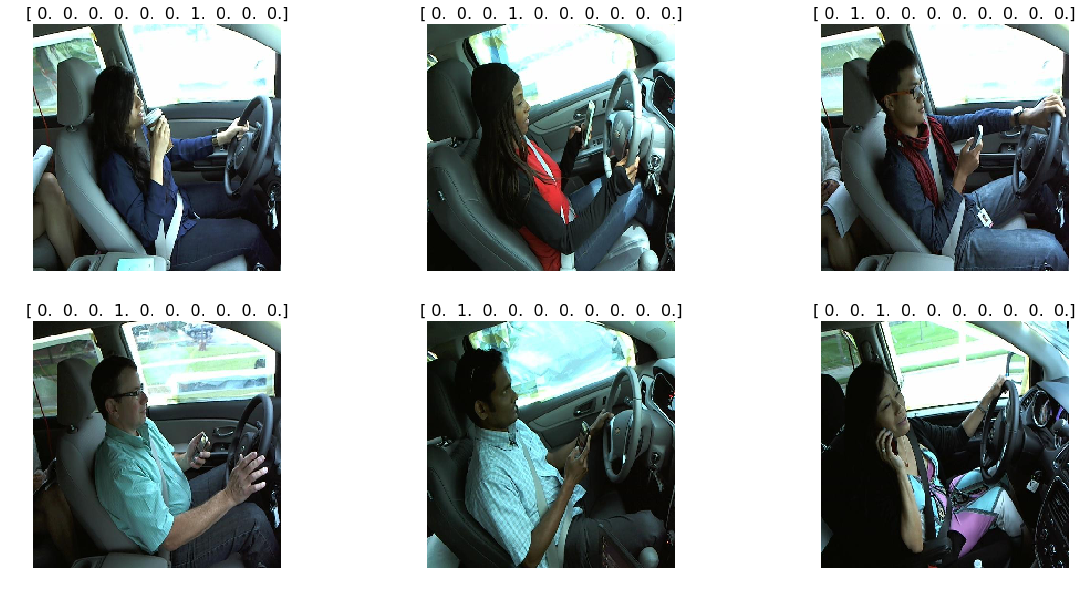

In [22]:
batches = get_batches('train', batch_size=6)
imgs,labels = next(batches)
# Plot randomly 6 images
plots(imgs, titles=labels, figsize=(20,10), rows =2)

Found 5000 images belonging to 10 classes.


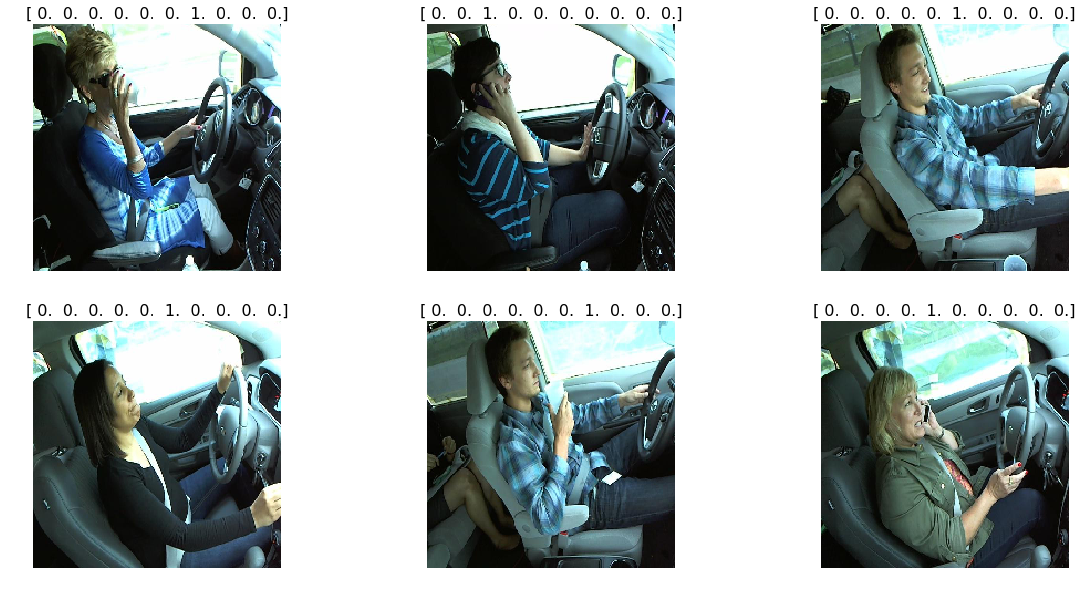

In [23]:
batches = get_batches('valid', batch_size=6)
imgs,labels = next(batches)

# Plot randomly 6 images
plots(imgs, titles=labels, figsize=(20,10), rows =2)

## 1.3 Batches preparation

### Batches as direct inputs

<span style="color:red"> WARNING: These lines are only to run once. </span>

In [24]:
# Roll into pixcel matrix
train_data = get_data('train')
valid_data = get_data('valid')

Found 16774 images belonging to 10 classes.
Found 5000 images belonging to 10 classes.


In [25]:
%pwd
%cd $path

C:\Users\User\Downloads\udacity\project\imgs


In [34]:

(valid_classes, train_classes, valid_labels, train_labels, valid_filenames, train_filenames) = get_classes(path)

Found 16774 images belonging to 10 classes.
Found 5000 images belonging to 10 classes.


In [26]:
save_array('results/train_data.dat', train_data)
save_array('results/valid_data.dat', valid_data)

<span style="color:red">End  WARNING </span>

Loading labels and stored data.

In [27]:
test_data = get_data('test')
len(test_data)

Found 6 images belonging to 1 classes.


6

In [28]:
%cd $path

C:\Users\User\Downloads\udacity\project\imgs


## 1.3 Summary


# 2. Experiements

We will start with the simpliest model: a fully connected network with no hidden layer, i.e., linear model. This is to provide a benchmark for subsequence development.

Notes:

- We used  batchnormalization right at the input layer to avoid any domination input values that could skew the output.
- We activated the output with a softmax layer for 10 classes.
- We will 224x224 input shape, as the results we will have 1.5+ million parametters and easily overfitted with a linear model, hence, l2 regularization is used to minimize impact of overfitting.

## 2.1 Linear model

In [29]:
Linear_model = Sequential([
        BatchNormalization(axis=-1, input_shape=(224,224,3)),
        Flatten(),
        Dense(10, activation='softmax')
    ])

Linear_model.compile(Adam(lr=10e-5), loss='categorical_crossentropy', metrics=['accuracy'])
Linear_model.summary()            


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_2 (Batch (None, 224, 224, 3)       12        
_________________________________________________________________
flatten_2 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1505290   
Total params: 1,505,302
Trainable params: 1,505,296
Non-trainable params: 6
_________________________________________________________________


In [30]:
if 'session' in locals() and session is not None:
    print('Close interactive session')
    session.close()

In [31]:
import tensorflow as tf

allow_soft_placement=True
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=.2, allow_growth = 1)

Training 10 epochs.

In [35]:
batch_size=32
Ex1_history = Linear_model.fit(train_data,train_labels, batch_size=batch_size, epochs=5,
                               validation_data =(valid_data,valid_labels))

Train on 16774 samples, validate on 5000 samples
Epoch 1/5
16774/16774 [==============================] - 175s - loss: 0.8099 - acc: 0.7950 - val_loss: 0.6078 - val_acc: 0.8584
Epoch 2/5
16774/16774 [==============================] - 175s - loss: 0.2166 - acc: 0.9360 - val_loss: 0.2855 - val_acc: 0.9360
Epoch 3/5
16774/16774 [==============================] - 170s - loss: 0.1774 - acc: 0.9512 - val_loss: 0.1343 - val_acc: 0.9650
Epoch 4/5
16774/16774 [==============================] - 175s - loss: 0.1297 - acc: 0.9683 - val_loss: 0.2260 - val_acc: 0.9468
Epoch 5/5
16774/16774 [==============================] - 169s - loss: 0.1140 - acc: 0.9697 - val_loss: 0.1852 - val_acc: 0.9618


In [385]:
# list all data in history
print(Ex1_history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


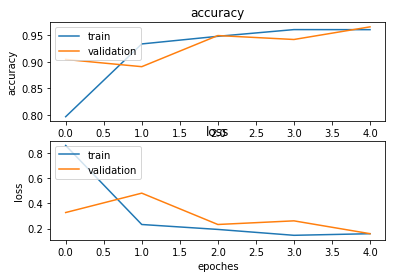

In [99]:
plot_history(Ex1_history)

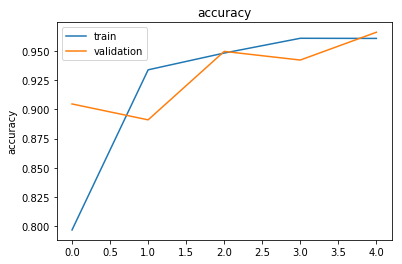

In [103]:
plot_acc(Ex1_history)

In [253]:
predictions = Linear_model.predict(train_data)
predictions = np.argmax(predictions, axis=-1)

In [548]:
predictions

array([0, 0, 0, ..., 9, 9, 9], dtype=int64)

In [221]:
train_labels2 = np.argmax(train_labels, axis=-1)

In [549]:
f1_score(train_labels2, predictions, average=None)

array([ 0.98,  0.98,  0.98,  0.99,  0.99,  0.99,  0.97,  1.  ,  0.98,  0.99])

In [257]:
valid_labels2 = np.argmax(valid_labels, axis=-1)

In [259]:
predictions_v = Linear_model.predict(valid_data)
predictions_v = np.argmax(predictions_v, axis=-1)

In [261]:
valid_labels2

array([0, 0, 0, ..., 9, 9, 9], dtype=int64)

In [262]:
predictions_v

array([0, 0, 0, ..., 9, 9, 9], dtype=int64)

In [550]:
f1_score(valid_labels2, predictions_v, average=None)

array([ 0.96,  0.96,  0.97,  0.98,  0.98,  0.97,  0.94,  0.99,  0.94,  0.97])

In [414]:
valid_data.shape

(5000, 224, 224, 3)

In [416]:
valid_data[:3].shape

(3, 224, 224, 3)

Confusion matrix, without normalization
[[1905   27    3    1    4   26   21    0    1    1]
 [   0 1767    0    0    0    0    0    0    0    0]
 [   0   14 1777    1    0    1   23    1    0    0]
 [   0   21    3 1813    4    2    3    0    0    0]
 [   0    4    0    2 1792    3   24    1    0    0]
 [   1    0    0    0    0 1809    0    0    2    0]
 [   0    1    0    0    0    2 1822    0    0    0]
 [   0    1    1    0    0    1    3 1495    1    0]
 [   0    3    3    2    2    7   20    2 1111    2]
 [   0    2    6    1    0    3    7    2    3 1214]]
Normalized confusion matrix
[[  9.58e-01   1.36e-02   1.51e-03   5.03e-04   2.01e-03   1.31e-02
    1.06e-02   0.00e+00   5.03e-04   5.03e-04]
 [  0.00e+00   1.00e+00   0.00e+00   0.00e+00   0.00e+00   0.00e+00
    0.00e+00   0.00e+00   0.00e+00   0.00e+00]
 [  0.00e+00   7.71e-03   9.78e-01   5.50e-04   0.00e+00   5.50e-04
    1.27e-02   5.50e-04   0.00e+00   0.00e+00]
 [  0.00e+00   1.14e-02   1.63e-03   9.82e-01   2.17e-03

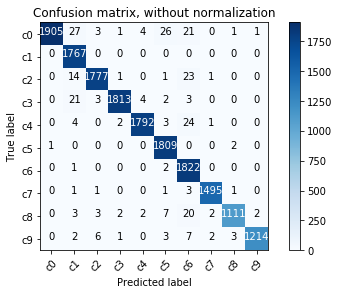

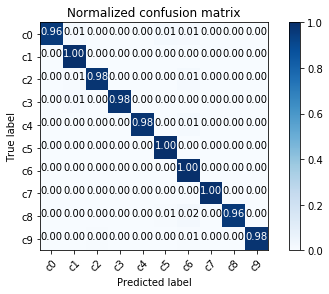

In [266]:
class_names=['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9']
cnf_matrix = confusion_matrix(train_labels2, predictions)

np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [106]:
acts = ["driving safely",
           "texting - right",
            "talking on the phone - right",
            "texting - left",
            "talking on the phone - left",
            "operating the radio",
            "drinking",
            "reaching behind", 
            "doing hair and makeup",
            "talking to passenger"]
batches = get_data("test", batch_size=2)
batch = get_batches("test", batch_size=2)
for i in batches:
    predictions_test = Linear_model.predict(i.reshape(1,224, 224, 3)) 
    predictions_test = np.argmax(predictions_test, axis=-1)
    predictions_test = np.array(predictions_test, np.int32)
    print (predictions_test)
    print("dricer is {}".format(acts[predictions_test[0]]))
    
    
    

Found 6 images belonging to 1 classes.
Found 6 images belonging to 1 classes.
[5]
dricer is operating the radio
[8]
dricer is doing hair and makeup
[1]
dricer is texting - right
[9]
dricer is talking to passenger
[0]
dricer is driving safely
[3]
dricer is texting - left


In [107]:
def driver_activity_detector(img_path, batch_size=batch_size):
    
    acts = ["driving safely",
           "texting - right",
            "talking on the phone - right",
            "texting - left",
            "talking on the phone - left",
            "operating the radio",
            "drinking",
            "reaching behind", 
            "doing hair and makeup",
            "talking to passenger"]
    activity = driver_activity(img_path)
    for i in batches:
        activity = Linear_model.predict(i.reshape(1,224, 224, 3)) 
        activity = np.argmax(activity, axis=-1)
        print("dricer is {}".format(acts[activity]))
            
    
    # Display the image
    batches = get_batches(img_path, batch_size=batch_size)
    imgs,j = next(batches)
    plots(imgs, titles=j, figsize=(20,10), rows =2)
    

In [118]:
%pwd
%cd ..

C:\Users\User\Downloads\Udacity\project


In [129]:
Linear_model.save_weights(path+'/models/Linear_model.h5')

It can be seen that the linear model with batchnormalization and some l2 regulation actually work pretty well. I can achive validation accuracy of around 94% on the validation dataset. However, the validation accuracy is not stable (even training accuracy is not stable), it means that model will not generalize very well but for starting model, this is very encouraging and it is clearly much better than random guess. 

Next I will try to stablize the validation accuracy with convolutional networks.

## 2.2 Simple convolutional layer network

Next, I experiment a neural network with 2 convolutional layers. This experiment will give us an idea on how this dataset behave under convolutional actions. I will try to overfitting and later adding some regularization or data augmentation.

In [44]:
CNN_simple = Sequential([
            BatchNormalization(input_shape=(224,224,3)),
            Conv2D(32,(3,3), activation='relu'),
            BatchNormalization(),
            MaxPooling2D((3,3)),
            #GlobalAveragePooling2D(data_format=None),
            Conv2D(64,(3,3), activation='relu'),
            BatchNormalization(),
            
            MaxPooling2D((3,3)),
            Flatten(),
            Dense(200, activation='relu'),
            
            BatchNormalization(),
            
            Dense(10, activation='softmax')
        ])

CNN_simple.compile(Adam(lr=10e-5), loss='categorical_crossentropy', metrics=['accuracy'])
CNN_simple.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_69 (Batc (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
batch_normalization_70 (Batc (None, 222, 222, 32)      128       
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
batch_normalization_71 (Batc (None, 72, 72, 64)        256       
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 24, 24, 64)        0         
__________

In [102]:
batch_size=32
Ex2_history = CNN_simple.fit(train_data,train_labels, batch_size=batch_size, epochs=5, 
                             validation_data =(valid_data,valid_labels))

Train on 16774 samples, validate on 5000 samples
Epoch 1/5
16774/16774 [==============================] - 2489s - loss: 0.2583 - acc: 0.9329 - val_loss: 0.1536 - val_acc: 0.9730
Epoch 2/5
16774/16774 [==============================] - 2408s - loss: 0.0248 - acc: 0.9964 - val_loss: 0.0615 - val_acc: 0.9850
Epoch 3/5
16774/16774 [==============================] - 2396s - loss: 0.0132 - acc: 0.9987 - val_loss: 0.0189 - val_acc: 0.9968
Epoch 4/5
16774/16774 [==============================] - 2341s - loss: 0.0051 - acc: 0.9996 - val_loss: 0.0126 - val_acc: 0.9964
Epoch 5/5
16774/16774 [==============================] - 2283s - loss: 0.0020 - acc: 1.0000 - val_loss: 0.0089 - val_acc: 0.9978


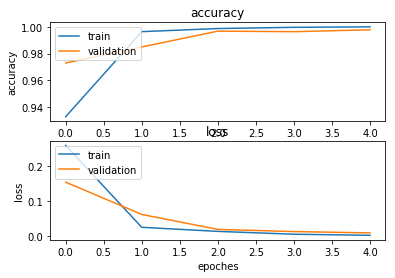

In [104]:
plot_history(Ex2_history)

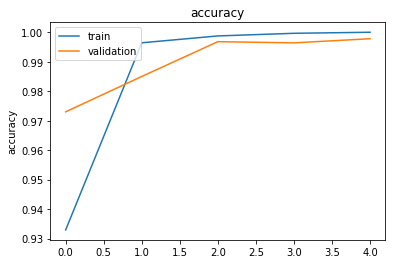

In [239]:
plot_acc(Ex2_history)

In [271]:
predictions_Ex2 = CNN_simple.predict(train_data)
predictions_Ex2 = np.argmax(predictions_Ex2, axis=-1)
train_labels_Ex2 = np.argmax(train_labels, axis=-1)
f1_score(train_labels_Ex2, predictions_Ex2, average=None)

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [274]:
predictions_Ex2_v = CNN_simple.predict(valid_data)
predictions_Ex2_v = np.argmax(predictions_Ex2_v, axis=-1)
valid_labels_Ex2 = np.argmax(valid_labels, axis=-1)
f1_score(valid_labels_Ex2, predictions_Ex2_v, average=None)

array([ 1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  0.99,  0.99])

Confusion matrix, without normalization
[[1989    0    0    0    0    0    0    0    0    0]
 [   0 1767    0    0    0    0    0    0    0    0]
 [   0    0 1817    0    0    0    0    0    0    0]
 [   0    0    0 1846    0    0    0    0    0    0]
 [   0    0    0    0 1826    0    0    0    0    0]
 [   0    0    0    0    0 1812    0    0    0    0]
 [   0    0    0    0    0    0 1825    0    0    0]
 [   0    0    0    0    0    0    0 1502    0    0]
 [   0    0    0    0    0    0    0    0 1152    0]
 [   0    0    0    0    0    0    0    0    0 1238]]
Normalized confusion matrix
[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0. 

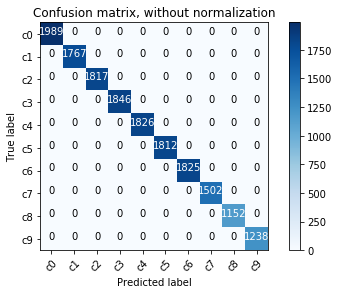

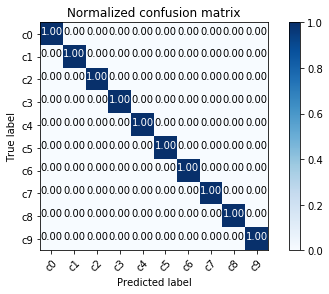

In [275]:
class_names=['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9']
cnf_matrix = confusion_matrix(train_labels_Ex2, predictions_Ex2)

np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

Confusion matrix, without normalization
[[500   0   0   0   0   0   0   0   0   0]
 [  0 500   0   0   0   0   0   0   0   0]
 [  0   0 500   0   0   0   0   0   0   0]
 [  0   0   0 500   0   0   0   0   0   0]
 [  0   0   0   0 500   0   0   0   0   0]
 [  1   0   0   0   0 497   1   0   1   0]
 [  0   0   0   0   0   0 500   0   0   0]
 [  0   0   0   0   0   0   0 500   0   0]
 [  0   0   0   0   0   0   1   0 495   4]
 [  0   0   0   0   0   0   0   0   3 497]]
Normalized confusion matrix
[[ 1.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    1.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    1.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    1.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    1.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.99  0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    1.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    1.    0.    0. 

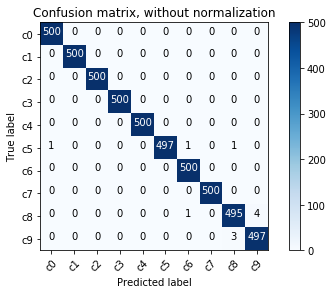

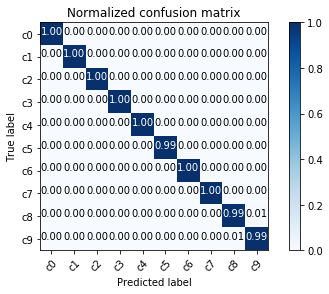

In [276]:
class_names=['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9']
cnf_matrix = confusion_matrix(valid_labels_Ex2, predictions_Ex2_v)

np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [106]:
CNN_simple.save_weights(path+'models/CNN_simple.h5')

With 4 epochs, I was able to get to 99% accuracy, however, It is slightly overfitting the model, I will add some reularization or specifically dropout to see if I can stablize the accuracy reading a bit more.

## 2.2 Simple convolutional layer network with dropout

Since I will add dropout, e.i., losing some information in order to simplify the model so that we can generalize better but losing information also cause the network less sophisticated, to have a "good" trade-off, I add one more convolutional layer.

In [52]:
CNN_dropout = Sequential([
        BatchNormalization(input_shape=(224,224,3)),
        Conv2D(32,(3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(),
    
        Conv2D(64,(3,3), activation='relu'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
    
        Conv2D(128,(3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(),
        
        Conv2D(256,(3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(),
        AveragePooling2D(),
    
        Flatten(),
        Dense(200, activation='relu'),
        BatchNormalization(),
    
        Dropout(0.5),
        Dense(200, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])
CNN_dropout.compile(Adam(lr=10e-5), loss='categorical_crossentropy', metrics=['accuracy'])
CNN_dropout.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_117 (Bat (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
batch_normalization_118 (Bat (None, 222, 222, 32)      128       
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
batch_normalization_119 (Bat (None, 109, 109, 64)      436       
_________________________________________________________________
max_pooling2d_67 (MaxPooling (None, 54, 54, 64)        0         
__________

In [134]:
batch_size=32
Ex3_history = CNN_dropout.fit(train_data,train_labels, batch_size=batch_size, epochs=2, 
                              validation_data =(valid_data,valid_labels))

Train on 16774 samples, validate on 5000 samples
Epoch 1/2
16774/16774 [==============================] - 237s 14ms/step - loss: -105.7810 - acc: 0.6892 - val_loss: -33.3225 - val_acc: 0.9612
Epoch 2/2
16774/16774 [==============================] - 288s 17ms/step - loss: -185.9037 - acc: 0.9785 - val_loss: -47.0898 - val_acc: 0.9930


In [108]:
Ex3_history = CNN_dropout.fit(train_data,train_labels, batch_size=batch_size, epochs=5, 
                              validation_data =(valid_data,valid_labels))

Train on 16774 samples, validate on 5000 samples
Epoch 1/5
16774/16774 [==============================] - 4820s - loss: 1.6404 - acc: 0.5048 - val_loss: 0.5544 - val_acc: 0.8476
Epoch 2/5
16774/16774 [==============================] - 4894s - loss: 0.5402 - acc: 0.8281 - val_loss: 0.1174 - val_acc: 0.9742
Epoch 3/5
16774/16774 [==============================] - 5652s - loss: 0.2553 - acc: 0.9250 - val_loss: 0.0699 - val_acc: 0.9836
Epoch 4/5
16774/16774 [==============================] - 5774s - loss: 0.1653 - acc: 0.9534 - val_loss: 0.0375 - val_acc: 0.9900
Epoch 5/5
16774/16774 [==============================] - 5587s - loss: 0.1119 - acc: 0.9683 - val_loss: 0.0555 - val_acc: 0.9842


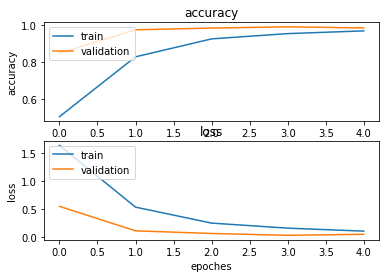

In [109]:
plot_history(Ex3_history)

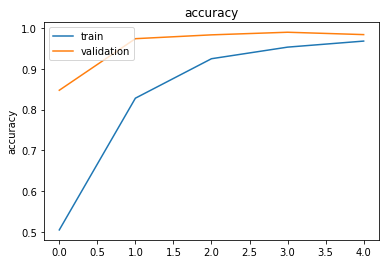

In [110]:
plot_acc(Ex3_history)

In [277]:
predictions_Ex3 = CNN_dropout.predict(train_data)
predictions_Ex3 = np.argmax(predictions_Ex3, axis=-1)
train_labels_Ex3 = np.argmax(train_labels, axis=-1)
f1_score(train_labels_Ex3, predictions_Ex3, average=None)


array([ 0.99,  1.  ,  1.  ,  1.  ,  0.99,  0.99,  0.99,  1.  ,  0.98,  0.99])

In [279]:
predictions_Ex3_v = CNN_dropout.predict(valid_data)
predictions_Ex3_v = np.argmax(predictions_Ex3_v, axis=-1)
valid_labels_Ex3 = np.argmax(valid_labels, axis=-1)
f1_score(valid_labels_Ex3, predictions_Ex3_v, average=None)

array([ 0.97,  1.  ,  0.99,  1.  ,  0.99,  0.99,  0.98,  0.99,  0.96,  0.97])

Confusion matrix, without normalization
[[1983    0    0    0    4    0    0    0    0    2]
 [   2 1763    0    0    0    0    0    0    0    2]
 [   0    1 1812    0    1    0    0    1    1    1]
 [   3    0    0 1841    2    0    0    0    0    0]
 [   0    0    0    3 1823    0    0    0    0    0]
 [   2    0    1    0    0 1809    0    0    0    0]
 [   0    4    2    0    9   17 1788    0    1    4]
 [   2    0    0    0    0    0    0 1500    0    0]
 [  13    0    3    0    4    1    0    4 1120    7]
 [   9    0    0    0    1    1    0    0    2 1225]]
Normalized confusion matrix
[[  9.97e-01   0.00e+00   0.00e+00   0.00e+00   2.01e-03   0.00e+00
    0.00e+00   0.00e+00   0.00e+00   1.01e-03]
 [  1.13e-03   9.98e-01   0.00e+00   0.00e+00   0.00e+00   0.00e+00
    0.00e+00   0.00e+00   0.00e+00   1.13e-03]
 [  0.00e+00   5.50e-04   9.97e-01   0.00e+00   5.50e-04   0.00e+00
    0.00e+00   5.50e-04   5.50e-04   5.50e-04]
 [  1.63e-03   0.00e+00   0.00e+00   9.97e-01   1.08e-03

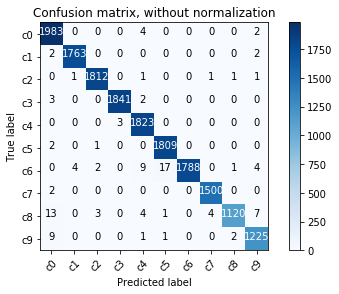

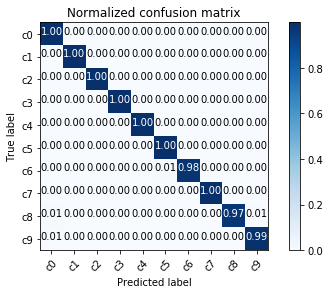

In [278]:
class_names=['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9']
cnf_matrix = confusion_matrix(train_labels_Ex3, predictions_Ex3)

np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

Confusion matrix, without normalization
[[494   0   0   0   1   2   0   0   0   3]
 [  1 499   0   0   0   0   0   0   0   0]
 [  0   1 498   0   1   0   0   0   0   0]
 [  1   0   0 497   2   0   0   0   0   0]
 [  0   0   0   0 500   0   0   0   0   0]
 [  1   0   0   0   0 498   0   0   0   1]
 [  1   1   3   0   2   7 481   1   1   3]
 [  0   0   1   0   0   0   0 499   0   0]
 [  9   0   3   0   2   3   0   5 465  13]
 [  9   0   0   0   0   0   0   1   0 490]]
Normalized confusion matrix
[[ 0.99  0.    0.    0.    0.    0.    0.    0.    0.    0.01]
 [ 0.    1.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    1.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.99  0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    1.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    1.    0.    0.    0.    0.  ]
 [ 0.    0.    0.01  0.    0.    0.01  0.96  0.    0.    0.01]
 [ 0.    0.    0.    0.    0.    0.    0.    1.    0.    0. 

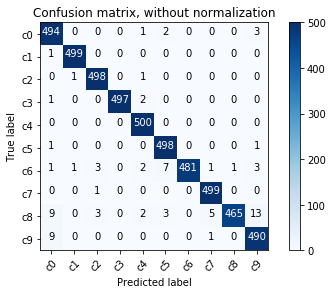

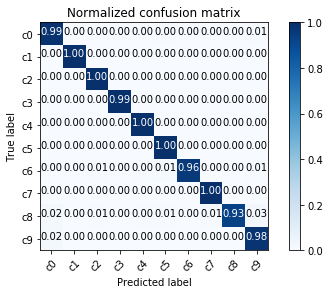

In [280]:
class_names=['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9']
cnf_matrix = confusion_matrix(valid_labels_Ex3, predictions_Ex3_v)

np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [122]:
CNN_dropout.save_weights(path+'models/CNN_dropout.h5')

## 2.4. Using vgg16 model without pre-trained weights

- Preprocessing input data specifically for vgg network
- Put common blocks into functions
- Add batchnormalixation layers (since vgg16 was invented before the introduction of batchnorn , original vgg16 does not contain batchnorm layers)

### vgg16 model construction

### Batches as outputs from vgg16 pretained weights

I will leverage the pre-trained imageNet weights available for vgg16 models.

To do this, it is easier to precompute outputs of vgg16's convolutional part and use these outputs as our inputs to our models. This process will help to save time as well as memory.

In [54]:
from keras.applications.vgg16 import VGG16
vgg_model_orig = VGG16(weights='imagenet', include_top=True)

Freeze the convolutional part

In [55]:
# Pop all the layers in Vgg model
layers = vgg_model_orig.layers
# Find all the index of Convolution2D layers
Con2D_layer_idx = [index for index,layer in enumerate(layers) if type(layer) is Conv2D]
# Call the index of the last Convolution2D layer
layer_idx = Con2D_layer_idx[-1]

# Find out what it is
layer_idx

17

In [56]:
Con2D_layer_idx

[1, 2, 4, 5, 7, 8, 9, 11, 12, 13, 15, 16, 17]

In [57]:
vgg_model_orig.output.shape

TensorShape([Dimension(None), Dimension(1000)])

In [58]:
# Create convolutional model up to layer 30
conv_model = Sequential(layers[:layer_idx+1])
conv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [78]:
x = conv_model.output
x = MaxPooling2D()(x)
x = AveragePooling2D()(x)
x = MaxPooling2D()(x)


x = Flatten()(x)

x = Dense(4096, activation='relu')(x)
x = BatchNormalization()(x)

x = Dropout(0.5)(x)

x = Dense(4096, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

output = Dense(10, activation='softmax')(x) # output 10 classes
vgg_model = Model(inputs = conv_model.input, outputs = output)

In [79]:
# Set all the convolutional layers to nontrainable
for layer in conv_model.layers:
    layer.trainable = False
vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [80]:
vgg_model.compile(Adam(lr=10e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [118]:
batch_size = 1
Ex41_history = vgg_model.fit(train_data,train_labels, batch_size=batch_size, epochs=3, 
                              validation_data =(valid_data,valid_labels))

Train on 16774 samples, validate on 5000 samples
Epoch 1/3
16774/16774 [==============================] - 14618s - loss: 2.2926 - acc: 0.1146 - val_loss: 14.4584 - val_acc: 0.1028
Epoch 2/3
16774/16774 [==============================] - 15513s - loss: 2.2930 - acc: 0.1118 - val_loss: 14.4540 - val_acc: 0.1026
Epoch 3/3
16774/16774 [==============================] - 14967s - loss: 2.2929 - acc: 0.1108 - val_loss: 14.3356 - val_acc: 0.1098


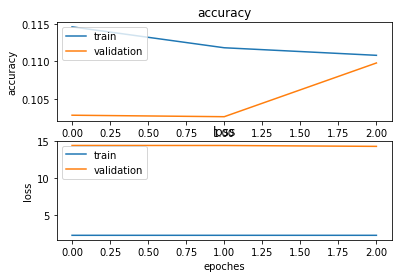

In [119]:
plot_history(Ex41_history)

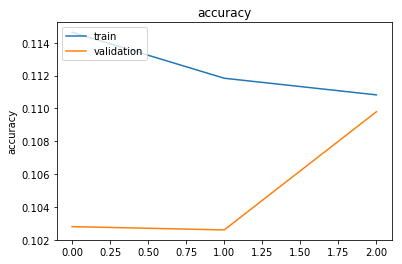

In [120]:
plot_acc(Ex41_history)

In [286]:
predictions_Ex41 = vgg_model.predict(train_data)
predictions_Ex41 = np.argmax(predictions_Ex41, axis=-1)
train_labels_Ex41 = np.argmax(train_labels, axis=-1)
f1_score(train_labels_Ex41, predictions_Ex41, average=None)

array([ 0.2 ,  0.14,  0.  ,  0.12,  0.03,  0.  ,  0.03,  0.12,  0.05,  0.15])

In [290]:
predictions_Ex41_v = vgg_model.predict(valid_data)
predictions_Ex41_v = np.argmax(predictions_Ex41_v, axis=-1)
valid_labels_Ex41 = np.argmax(valid_labels, axis=-1)
f1_score(valid_labels_Ex41, predictions_Ex41_v, average=None)

array([ 0.16,  0.13,  0.01,  0.1 ,  0.03,  0.  ,  0.04,  0.13,  0.07,  0.17])

Confusion matrix, without normalization
[[1983    0    0    0    4    0    0    0    0    2]
 [   2 1763    0    0    0    0    0    0    0    2]
 [   0    1 1812    0    1    0    0    1    1    1]
 [   3    0    0 1841    2    0    0    0    0    0]
 [   0    0    0    3 1823    0    0    0    0    0]
 [   2    0    1    0    0 1809    0    0    0    0]
 [   0    4    2    0    9   17 1788    0    1    4]
 [   2    0    0    0    0    0    0 1500    0    0]
 [  13    0    3    0    4    1    0    4 1120    7]
 [   9    0    0    0    1    1    0    0    2 1225]]
Normalized confusion matrix
[[  9.97e-01   0.00e+00   0.00e+00   0.00e+00   2.01e-03   0.00e+00
    0.00e+00   0.00e+00   0.00e+00   1.01e-03]
 [  1.13e-03   9.98e-01   0.00e+00   0.00e+00   0.00e+00   0.00e+00
    0.00e+00   0.00e+00   0.00e+00   1.13e-03]
 [  0.00e+00   5.50e-04   9.97e-01   0.00e+00   5.50e-04   0.00e+00
    0.00e+00   5.50e-04   5.50e-04   5.50e-04]
 [  1.63e-03   0.00e+00   0.00e+00   9.97e-01   1.08e-03

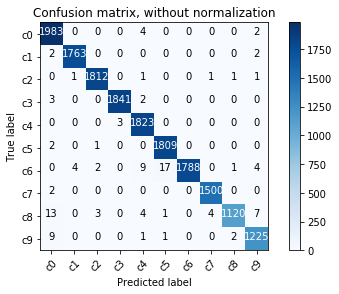

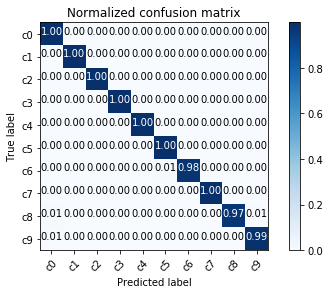

In [284]:
class_names=['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9']
cnf_matrix = confusion_matrix(train_labels_Ex41, predictions_Ex41)

np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

Confusion matrix, without normalization
[[494   0   0   0   1   2   0   0   0   3]
 [  1 499   0   0   0   0   0   0   0   0]
 [  0   1 498   0   1   0   0   0   0   0]
 [  1   0   0 497   2   0   0   0   0   0]
 [  0   0   0   0 500   0   0   0   0   0]
 [  1   0   0   0   0 498   0   0   0   1]
 [  1   1   3   0   2   7 481   1   1   3]
 [  0   0   1   0   0   0   0 499   0   0]
 [  9   0   3   0   2   3   0   5 465  13]
 [  9   0   0   0   0   0   0   1   0 490]]
Normalized confusion matrix
[[ 0.99  0.    0.    0.    0.    0.    0.    0.    0.    0.01]
 [ 0.    1.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    1.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.99  0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    1.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    1.    0.    0.    0.    0.  ]
 [ 0.    0.    0.01  0.    0.    0.01  0.96  0.    0.    0.01]
 [ 0.    0.    0.    0.    0.    0.    0.    1.    0.    0. 

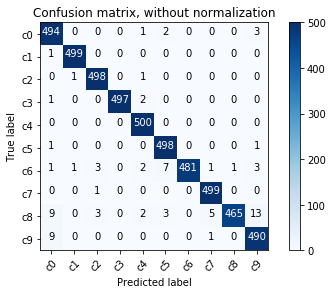

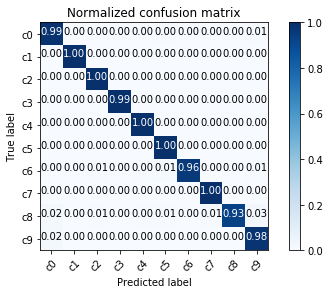

In [285]:
class_names=['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9']
cnf_matrix = confusion_matrix(valid_labels_Ex41, predictions_Ex41_v)

np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [123]:
vgg_model.save_weights(path+'models/vgg_model.h5')

## 2.5 Using InceptionV3 model with transfered learning (pretrained weights)

In this experiment, we will use InceptionV3 model with pre-trained imageNet weights. We will first start with the base model with slightly modification of the top layer to adapt with 10 classes instead 1000 classes. 

### Base model

In [84]:
from keras.applications.inception_v3 import InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(10, activation='softmax')(x) # output 10 classes
IcepV3_model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False
IcepV3_model.compile(Adam(lr=10e-5), loss='categorical_crossentropy', metrics=['accuracy'])
IcepV3_model.summary()

87826432/87910968 [============================>.] - ETA: 0s____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
conv2d_252 (Conv2D)              (None, None, None, 32 864         input_4[0][0]                    
____________________________________________________________________________________________________
batch_normalization_328 (BatchNo (None, None, None, 32 96          conv2d_252[0][0]                 
____________________________________________________________________________________________________
activation_189 (Activation)      (None, None, None, 32 0           batch_normalization_328[0][0]    
_______________________________

In [85]:
batch_size=32
Ex4_history = IcepV3_model.fit(train_data,train_labels, batch_size=batch_size, epochs=3, 
                              validation_data =(valid_data,valid_labels))

Train on 16774 samples, validate on 5000 samples
Epoch 1/3
16774/16774 [==============================] - 3654s - loss: 1.4326 - acc: 0.5639 - val_loss: 0.8979 - val_acc: 0.7318
Epoch 2/3
16774/16774 [==============================] - 3654s - loss: 0.7781 - acc: 0.7829 - val_loss: 0.5889 - val_acc: 0.8428
Epoch 3/3
16774/16774 [==============================] - 3639s - loss: 0.5853 - acc: 0.8370 - val_loss: 0.4632 - val_acc: 0.8762


In [86]:
Ex4_history = IcepV3_model.fit(train_data,train_labels, batch_size=batch_size, epochs=5, 
                              validation_data =(valid_data,valid_labels))

Train on 16774 samples, validate on 5000 samples
Epoch 1/5
16774/16774 [==============================] - 3613s - loss: 0.4872 - acc: 0.8605 - val_loss: 0.4367 - val_acc: 0.8754
Epoch 2/5
16774/16774 [==============================] - 3595s - loss: 0.4147 - acc: 0.8812 - val_loss: 0.3730 - val_acc: 0.8940
Epoch 3/5
16774/16774 [==============================] - 3686s - loss: 0.3754 - acc: 0.8894 - val_loss: 0.3546 - val_acc: 0.8990
Epoch 4/5
16774/16774 [==============================] - 3621s - loss: 0.3242 - acc: 0.9085 - val_loss: 0.3383 - val_acc: 0.8996
Epoch 5/5
16774/16774 [==============================] - 4035s - loss: 0.2987 - acc: 0.9158 - val_loss: 0.2790 - val_acc: 0.9236


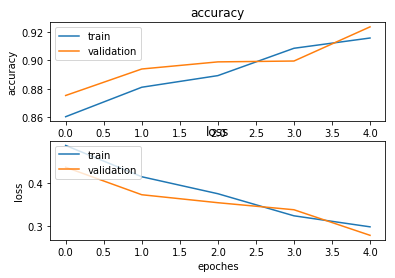

In [90]:
plot_history(Ex4_history)

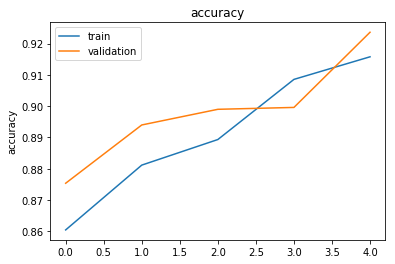

In [112]:
plot_acc(Ex4_history)

In [292]:
predictions_Ex4 = IcepV3_model.predict(train_data)
predictions_Ex4 = np.argmax(predictions_Ex4, axis=-1)
train_labels_Ex4 = np.argmax(train_labels, axis=-1)
f1_score(train_labels_Ex4, predictions_Ex4, average=None)

array([ 1.  ,  0.99,  0.99,  1.  ,  1.  ,  1.  ,  1.  ,  0.99,  1.  ,  1.  ])

In [295]:
predictions_Ex4_v = IcepV3_model.predict(valid_data)
predictions_Ex4_v = np.argmax(predictions_Ex4_v, axis=-1)
valid_labels_Ex4 = np.argmax(valid_labels, axis=-1)
f1_score(valid_labels_Ex4, predictions_Ex4_v, average=None)

array([ 0.99,  0.99,  0.98,  1.  ,  1.  ,  1.  ,  0.99,  0.98,  0.99,  0.99])

Confusion matrix, without normalization
[[1986    0    0    0    0    1    1    0    1    0]
 [   0 1762    0    0    0    0    0    1    0    4]
 [   0   30 1771    0    0    0    0   15    0    1]
 [   0    0    0 1846    0    0    0    0    0    0]
 [   0    0    0    0 1826    0    0    0    0    0]
 [   0    0    0    0    0 1811    0    1    0    0]
 [   0    0    0    0    0    0 1825    0    0    0]
 [   5    0    0    0    0    0    0 1495    1    1]
 [   0    0    0    0    1    0    0    3 1148    0]
 [   0    0    0    0    0    1    0    0    0 1237]]
Normalized confusion matrix
[[  9.98e-01   0.00e+00   0.00e+00   0.00e+00   0.00e+00   5.03e-04
    5.03e-04   0.00e+00   5.03e-04   0.00e+00]
 [  0.00e+00   9.97e-01   0.00e+00   0.00e+00   0.00e+00   0.00e+00
    0.00e+00   5.66e-04   0.00e+00   2.26e-03]
 [  0.00e+00   1.65e-02   9.75e-01   0.00e+00   0.00e+00   0.00e+00
    0.00e+00   8.26e-03   0.00e+00   5.50e-04]
 [  0.00e+00   0.00e+00   0.00e+00   1.00e+00   0.00e+00

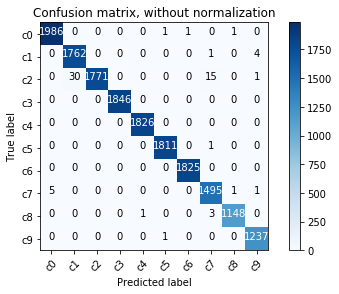

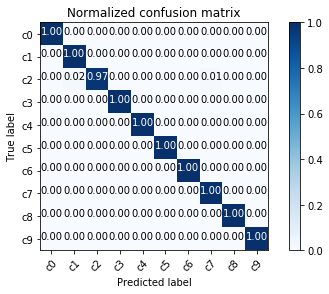

In [297]:
class_names=['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9']
cnf_matrix = confusion_matrix(train_labels_Ex4, predictions_Ex4)

np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

Confusion matrix, without normalization
[[495   0   0   2   0   0   1   2   0   0]
 [  0 499   0   0   0   0   0   1   0   0]
 [  0   6 486   0   1   0   3   4   0   0]
 [  0   0   0 500   0   0   0   0   0   0]
 [  0   0   0   0 500   0   0   0   0   0]
 [  0   0   0   1   0 498   0   1   0   0]
 [  0   0   0   0   0   0 500   0   0   0]
 [  5   0   0   0   0   0   0 495   0   0]
 [  1   0   1   0   0   1   2   3 488   4]
 [  0   0   0   2   0   0   0   0   2 496]]
Normalized confusion matrix
[[ 0.99  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    1.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.01  0.97  0.    0.    0.    0.01  0.01  0.    0.  ]
 [ 0.    0.    0.    1.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    1.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    1.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    1.    0.    0.    0.  ]
 [ 0.01  0.    0.    0.    0.    0.    0.    0.99  0.    0. 

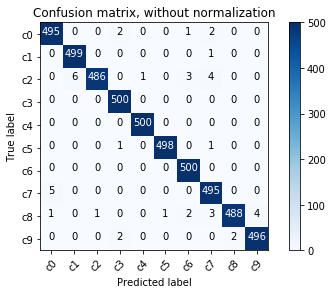

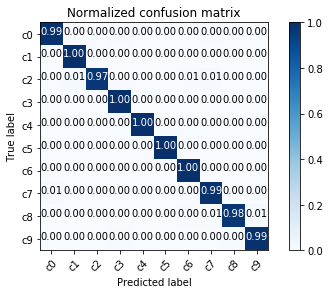

In [298]:
class_names=['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9']
cnf_matrix = confusion_matrix(valid_labels_Ex4, predictions_Ex4_v)

np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

We are already overfitting the model, validation accuaracy stays around 0.91 and it seems like Inception3 net without modification further layers will not preduce a good results.

### Further finetuning
Next, we will further fine-tune InceptionV3 models. We will freeze the first 172 layers and train the rest

In [88]:
# the first 172 layers and unfreeze the rest:
for layer in IcepV3_model.layers[:172]:
    layer.trainable = False
for layer in IcepV3_model.layers[172:]:
    layer.trainable = True

In [92]:
IcepV3_model.compile(Adam(lr=10e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [93]:
Ex5_history = IcepV3_model.fit(train_data,train_labels, batch_size=batch_size, epochs=5, 
                              validation_data =(valid_data,valid_labels))

Train on 16774 samples, validate on 5000 samples
Epoch 1/5
16774/16774 [==============================] - 5627s - loss: 0.1324 - acc: 0.9589 - val_loss: 0.0700 - val_acc: 0.9808
Epoch 2/5
16774/16774 [==============================] - 5203s - loss: 0.0212 - acc: 0.9937 - val_loss: 0.0243 - val_acc: 0.9918
Epoch 3/5
16774/16774 [==============================] - 4885s - loss: 0.0209 - acc: 0.9937 - val_loss: 0.0252 - val_acc: 0.9940
Epoch 4/5
16774/16774 [==============================] - 4807s - loss: 0.0318 - acc: 0.9914 - val_loss: 0.0245 - val_acc: 0.9934
Epoch 5/5
16774/16774 [==============================] - 4819s - loss: 0.0093 - acc: 0.9973 - val_loss: 0.0324 - val_acc: 0.9914


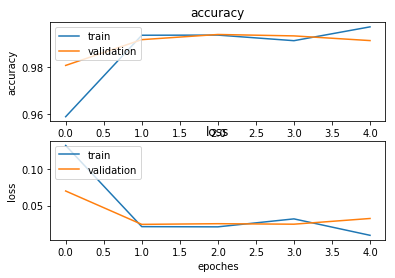

In [94]:
plot_history(Ex5_history)

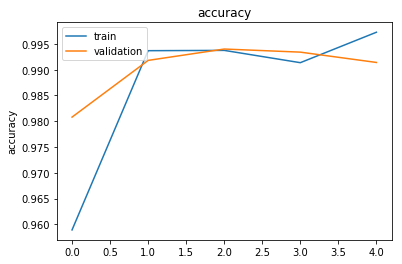

In [117]:
plot_acc(Ex5_history)

In [ ]:
predictions_Ex4 = IcepV3_model.predict(train_data)
predictions_Ex4 = np.argmax(predictions_Ex4, axis=-1)
train_labels_Ex4 = np.argmax(train_labels, axis=-1)
f1_score(train_labels_Ex4, predictions_Ex4, average=None)

In [ ]:
predictions_Ex4_v = IcepV3_model.predict(train_data)
predictions_Ex4_v = np.argmax(predictions_Ex4_v, axis=-1)
valid_labels_Ex4 = np.argmax(train_labels, axis=-1)
f1_score(valid_labels_Ex4, predictions_Ex4_v, average=None)

In [116]:
IcepV3_model.save_weights(path+'models/IcepV3_model.h5')

In [95]:
init_notebook_mode(connected=True)

In [102]:
import plotly as py
import plotly.graph_objs as go
feature_type = ["CNN - benchmark",
                "CNN -  with Conv2D",
                "CNN - with Dropout",
                "VGG16",
                "InceptionV3",
               "InceptionV3 - finetuning"]
acc_scores = [0.9618, 0.9978, 0.9842,0.1098,0.9236,0.9914]
loss_score = [0.1852,0.0089, 0.0555, 14.3356, 0.2790, 0.0324]

# Create a trace
trace = go.Bar(
    x = feature_type,
    y = loss_score,
    text = loss_score,
    textposition = 'auto',
    marker=dict(color='rgb(158,202,225)',
    line=dict(color='rgb(8,48,107)', width=1.5),),
    opacity=0.6
    #mode = 'lines+markers',
    #name = 'lines+markers'
)

layout = go.Layout(
    title="Model's loss",
    hovermode='closest',
    xaxis=dict(
        title='CNN Models'
    ),
    yaxis=dict(
        title='Loss'
    ),
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig, filename="bar_chart")

In [101]:
import plotly as py
import plotly.graph_objs as go
feature_type = ["CNN - benchmark",
                "CNN -  with Conv2D",
                "CNN - with Dropout",
                "VGG16",
                "InceptionV3",
               "InceptionV3 - finetuning"]
acc_scores = [0.9618, 0.9978, 0.9842,0.1098,0.9236,0.9914]
loss_score = [0.1852,0.0089, 0.0555, 14.3356, 0.2790, 0.0324]

# Create a trace
trace = go.Bar(
    x = feature_type,
    y = acc_scores,
    text = acc_scores,
    textposition = 'auto',
    marker=dict(color='rgb(158,202,225)',
    line=dict(color='rgb(8,48,107)', width=1.5),),
    opacity=0.6
    #mode = 'lines+markers',
    #name = 'lines+markers'
)

layout = go.Layout(
    title="Model's accuracy performance",
    hovermode='closest',
    xaxis=dict(
        title='CNN Models'
    ),
    yaxis=dict(
        title='Accuracy'
    ),
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig, filename="bar_chart")

In [140]:
def analyze_content(path):
    '''
    Stats about the content of the images
    '''
    df = pd.read_csv(path)
    columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
    subjects = df.drop_duplicates('subject')['subject'].tolist()
    new_df = pd.DataFrame(index=subjects, columns=columns)
    classes = df.drop_duplicates('classname')['classname'].tolist()

    print("Number of drivers: %d" % len(subjects))

    for subject in subjects:
        print("Analyzing subject %s" % subject)
        subject_data = df.loc[df['subject'] == subject]
        row = []
        for class_type in classes:
            images_data = subject_data.loc[df['classname'] == class_type]
            row.append(len(images_data))
        new_df.loc[subject] = row

    print(new_df)
    print(new_df.describe().loc[['mean', 'std', 'min', 'max']])

SyntaxError: invalid syntax (<ipython-input-140-9781f4f097b0>, line 16)

In [141]:
%pwd

'C:\\Users\\User\\Downloads\\udacity\\project\\imgs'

In [142]:
analyze_content('driver_imgs_list.csv')

Number of drivers: 26
Analyzing subject p002
Analyzing subject p012
Analyzing subject p014
Analyzing subject p015
Analyzing subject p016
Analyzing subject p021
Analyzing subject p022
Analyzing subject p024
Analyzing subject p026
Analyzing subject p035
Analyzing subject p039
Analyzing subject p041
Analyzing subject p042
Analyzing subject p045
Analyzing subject p047
Analyzing subject p049
Analyzing subject p050
Analyzing subject p051
Analyzing subject p052
Analyzing subject p056
Analyzing subject p061
Analyzing subject p064
Analyzing subject p066
Analyzing subject p072
Analyzing subject p075
Analyzing subject p081
       c0   c1   c2   c3   c4   c5   c6   c7   c8   c9
p002   76   74   86   79   84   76   83   72   44   51
p012   84   95   91   89   97   96   75   72   62   62
p014  100  103  100  100  103  102  101   77   38   52
p015   79   85   88   94  101  101   99   81   86   61
p016  111  102  101  128  104  104  108  101   99  120
p021  135  131  127  128  132  130  126   98   99 